# Transfer learning on microsoft/wavlm-base


With raw audio files all padded to 4s without data augmentation

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from transformers import set_seed, Wav2Vec2FeatureExtractor, WavLMForSequenceClassification, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
notebook_path = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_path, '../..'))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


In [4]:
# Set seed for reproducibility
seed = 42
set_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

## Load Dataset


In [5]:
df_train = pd.read_csv('../../data/train_dataset.csv')
df_train = df_train[['Filepath', 'Emotion']]
df_val = pd.read_csv('../../data/val_dataset.csv')
df_val = df_val[['Filepath', 'Emotion']]
df_test = pd.read_csv('../../data/test_dataset.csv')
df_test = df_test[['Filepath', 'Emotion']]

In [6]:
df_train

,Filepath,Emotion
0,./dataset/mlend\MLEndSND_Public\11093.wav,Question
1,./dataset/crema-d\AudioWAV\1011_TAI_ANG_XX.wav,Anger
2,./dataset/mlend\MLEndSND_Public\27019.wav,Neutral
3,./dataset/mlend\MLEndSND_Public\23420.wav,Bored
4,./dataset/crema-d\AudioWAV\1077_ITH_ANG_XX.wav,Anger
...,...,...
44216,./dataset/meld\train\dia873_utt1.mp4,Neutral
44217,./dataset/esd\0015\Happy\0015_000807.wav,Happy
44218,./dataset/mlend\MLEndSND_Public\40154.wav,Neutral
44219,./dataset/esd\0017\Sad\0017_001347.wav,Sad


In [7]:
df_val

,Filepath,Emotion
0,./dataset/esd\0020\Sad\0020_001395.wav,Sad
1,./dataset/meld\train\dia930_utt5.mp4,Neutral
2,./dataset/mlend\MLEndSND_Public\24481.wav,Bored
3,./dataset/crema-d\AudioWAV\1002_IEO_SAD_HI.wav,Sad
4,./dataset/esd\0011\Angry\0011_000373.wav,Anger
...,...,...
9471,./dataset/tess\YAF_disgust\YAF_take_disgust.wav,Disgust
9472,./dataset/mlend\MLEndSND_Public\43418.wav,Bored
9473,./dataset/mlend\MLEndSND_Public\02459.wav,Bored
9474,./dataset/mlend\MLEndSND_Public\10609.wav,Question


In [8]:
df_test

,Filepath,Emotion
0,./dataset/mlend\MLEndSND_Public\01620.wav,Neutral
1,./dataset/jl-corpus/Raw JL corpus (unchecked a...,Sad
2,./dataset/mlend\MLEndSND_Public\04997.wav,Question
3,./dataset/esd\0018\Surprise\0018_001454.wav,Surprise
4,./dataset/mlend\MLEndSND_Public\05521.wav,Neutral
...,...,...
9472,./dataset/tess\YAF_pleasant_surprised\YAF_half...,Surprise
9473,./dataset/esd\0019\Angry\0019_000651.wav,Anger
9474,./dataset/mlend\MLEndSND_Public\21688.wav,Neutral
9475,./dataset/esd\0020\Angry\0020_000377.wav,Anger


In [9]:
# Convert labels to integers
unique_labels = sorted(df_train['Emotion'].unique())
label_map = {label: idx for idx, label in enumerate(unique_labels)}
print(label_map)

df_train['Emotion'] = df_train['Emotion'].map(label_map)
df_val['Emotion'] = df_val['Emotion'].map(label_map)
df_test['Emotion'] = df_test['Emotion'].map(label_map)

{'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}


In [10]:
df_train

,Filepath,Emotion
0,./dataset/mlend\MLEndSND_Public\11093.wav,6
1,./dataset/crema-d\AudioWAV\1011_TAI_ANG_XX.wav,0
2,./dataset/mlend\MLEndSND_Public\27019.wav,5
3,./dataset/mlend\MLEndSND_Public\23420.wav,1
4,./dataset/crema-d\AudioWAV\1077_ITH_ANG_XX.wav,0
...,...,...
44216,./dataset/meld\train\dia873_utt1.mp4,5
44217,./dataset/esd\0015\Happy\0015_000807.wav,4
44218,./dataset/mlend\MLEndSND_Public\40154.wav,5
44219,./dataset/esd\0017\Sad\0017_001347.wav,7


In [11]:
df_val

,Filepath,Emotion
0,./dataset/esd\0020\Sad\0020_001395.wav,7
1,./dataset/meld\train\dia930_utt5.mp4,5
2,./dataset/mlend\MLEndSND_Public\24481.wav,1
3,./dataset/crema-d\AudioWAV\1002_IEO_SAD_HI.wav,7
4,./dataset/esd\0011\Angry\0011_000373.wav,0
...,...,...
9471,./dataset/tess\YAF_disgust\YAF_take_disgust.wav,2
9472,./dataset/mlend\MLEndSND_Public\43418.wav,1
9473,./dataset/mlend\MLEndSND_Public\02459.wav,1
9474,./dataset/mlend\MLEndSND_Public\10609.wav,6


In [12]:
df_test

,Filepath,Emotion
0,./dataset/mlend\MLEndSND_Public\01620.wav,5
1,./dataset/jl-corpus/Raw JL corpus (unchecked a...,7
2,./dataset/mlend\MLEndSND_Public\04997.wav,6
3,./dataset/esd\0018\Surprise\0018_001454.wav,8
4,./dataset/mlend\MLEndSND_Public\05521.wav,5
...,...,...
9472,./dataset/tess\YAF_pleasant_surprised\YAF_half...,8
9473,./dataset/esd\0019\Angry\0019_000651.wav,0
9474,./dataset/mlend\MLEndSND_Public\21688.wav,5
9475,./dataset/esd\0020\Angry\0020_000377.wav,0


In [13]:
# Wav2vec2 processor to process raw audio input into the correct format 
model_name = 'microsoft/wavlm-base'
processor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
model = WavLMForSequenceClassification.from_pretrained(
    model_name, num_labels=len(label_map))

Some weights of WavLMForSequenceClassification were not initialized from the model checkpoint at microsoft/wavlm-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
from transformer_models.emotion_datasets.SpeechEmotionDatasetStandardPad import SpeechEmotionDatasetStandardPad

In [15]:
# Load the dataset
train_dataset = SpeechEmotionDatasetStandardPad(df_train, processor)
val_dataset = SpeechEmotionDatasetStandardPad(df_val, processor)
test_dataset = SpeechEmotionDatasetStandardPad(df_test, processor)

In [16]:
train_dataset[0]

{'input_values': tensor([0.0010, 0.0013, 0.0008,  ..., 0.0000, 0.0000, 0.0000]),
 'labels': tensor(6)}

## Set Training Arguments


In [17]:
train_args = TrainingArguments(
    output_dir='../models/wavlm-base_standardpad',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    fp16=True,
    dataloader_num_workers=8,
    dataloader_pin_memory=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to=[]
)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
# Create function for computing metrics
def compute_metrics(pred):
    labels = pred.label_ids  # original labels
    preds = np.argmax(pred.predictions, axis=1)  # model predicted labels
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="weighted")
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

Import CustomTrainer and EarlyStoppingCallback

In [19]:
from transformer_models.trainer.CustomTrainer import CustomTrainer
from transformer_models.early_stopping.EarlyStopping import EarlyStoppingCallback

In [20]:
# Initialize the trainer
trainer = CustomTrainer(
    model=model,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    class_weights_path="../../data/class_weights.pt",
    callbacks=[EarlyStoppingCallback(patience=3, min_delta=0.001)]
)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\transformer_models\trainer\CustomTrainer.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.cla

In [21]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.697000,0.677465,0.773850,0.786201,0.773850,0.771919
2,0.516200,0.530925,0.809413,0.820516,0.809413,0.810560
3,0.449200,0.550448,0.828936,0.832702,0.828936,0.828620
4,0.408000,0.564132,0.846771,0.848909,0.846771,0.846741
5,0.330400,0.709104,0.852786,0.855425,0.852786,0.852133


Early stopping triggered after 3 epochs of no improvement.


TrainOutput(global_step=13820, training_loss=0.5538022644440448, metrics={'train_runtime': 2038.9909, 'train_samples_per_second': 216.877, 'train_steps_per_second': 13.556, 'total_flos': 8.03001905151936e+18, 'train_loss': 0.5538022644440448, 'epoch': 5.0})

In [22]:
results = trainer.evaluate()
print(results)

Early stopping triggered after 3 epochs of no improvement.
{'eval_loss': 0.7091035842895508, 'eval_accuracy': 0.8527859856479527, 'eval_precision': 0.8554251049077044, 'eval_recall': 0.8527859856479527, 'eval_f1': 0.852133083524166, 'eval_runtime': 39.1202, 'eval_samples_per_second': 242.228, 'eval_steps_per_second': 15.158, 'epoch': 5.0}


## Test Predictions


Test Accuracy: 0.8451
Test Precision: 0.8492
Test Recall: 0.8451
Test F1-score: 0.8449

              precision    recall  f1-score   support

       Anger       0.90      0.88      0.89       916
       Bored       0.92      0.87      0.89      1098
     Disgust       0.79      0.67      0.73       291
        Fear       0.91      0.59      0.72       308
       Happy       0.86      0.82      0.84      1914
     Neutral       0.76      0.86      0.81      2226
    Question       0.94      0.92      0.93      1139
         Sad       0.81      0.86      0.83       857
    Surprise       0.84      0.84      0.84       728

    accuracy                           0.85      9477
   macro avg       0.86      0.81      0.83      9477
weighted avg       0.85      0.85      0.84      9477



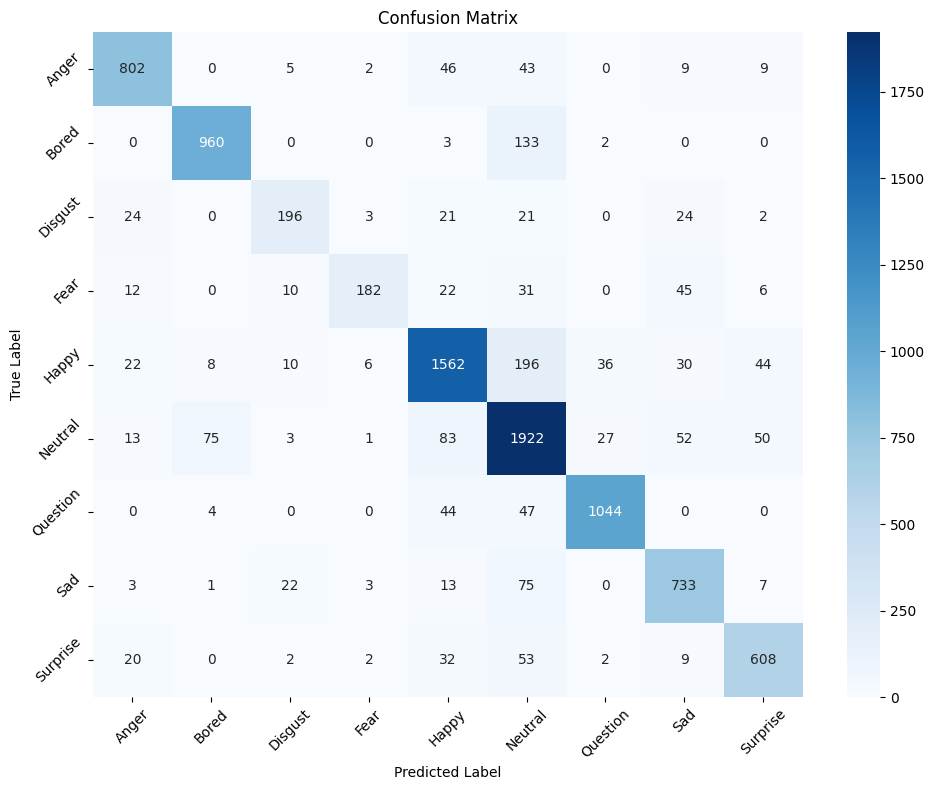

In [23]:
# Get model predictions on the test dataset
predictions = trainer.predict(test_dataset)
# Convert logits to predicted class labels
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids  # Ground truth labels

# Compute metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-score: {f1:.4f}\n")

# Print detailed classification report
print(classification_report(true_labels, pred_labels, target_names=list(label_map.keys())))

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_map.keys(), yticklabels=label_map.keys())

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.tight_layout()
plt.show()